In [52]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [53]:
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2023, 1, 14)

In [54]:
DATA = '../data'

sp1950 = pd.read_csv(f'{DATA}/sp1950.csv')
nya1965 = pd.read_csv(f'{DATA}/nya1965.csv')
nasdaq1965 = pd.read_csv(f'{DATA}/nasdaq1965.csv')
wilshire1990 = pd.read_csv(f'{DATA}/wilshire1990.csv')


nasdaq1965.tail()
states = pd.read_csv(f'{DATA}/hmm_exp_returns.csv')
states.index = pd.to_datetime(states.Date)
states.tail()

,Date,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp,mean_exp,state
Date,,,,,,,,,,,,,,,
2023-01-09,2023-01-09,3892.090088,0.999232,0.998528,15514.440430,0.998372,1.001036,10635.650391,1.006279,0.999644,38648.300781,1.000456,1.000569,0.999944,1
2023-01-10,2023-01-10,3919.250000,1.006978,0.998528,15608.169922,1.006041,1.001036,10742.629883,1.010059,1.000655,38950.468750,1.007818,1.000569,1.000197,1
2023-01-11,2023-01-11,3969.610107,1.012849,0.998528,15749.089844,1.009029,1.001036,10931.669922,1.017597,0.999644,39470.429688,1.013349,1.000569,0.999944,1
2023-01-12,2023-01-12,3983.169922,1.003416,0.998528,15859.549805,1.007014,1.001036,11001.099609,1.006351,1.000655,39663.089844,1.004881,1.000569,1.000197,1
2023-01-13,2023-01-13,3999.090088,1.003997,0.998528,15918.367188,1.003709,1.001036,11079.156250,1.007095,0.999644,39834.101562,1.004312,1.000569,0.999944,1


In [55]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ACN', 'ADBE', 'ADYEY', 'AMD', 'AMGN',
    'AMZN', 'ANET', 'ASML', 'AXON', 'BROS', 'BYND', 'CHWY', 'CRWD',
    'DDOG', 'DGX', 'DIS', 'DOCS', 'DOCU', 'DUOL', 'EDIT', 'ETSY',
    'FLGT', 'FTNT', 'GH', 'GMED', 'GOOG', 'IDXX', 'INTG', 'ISRG',
    'JD', 'LRCX', 'LSPD', 'LULU', 'MA', 'MASI', 'MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NET', 'NOW', 'NVCR', 'NVDA', 'ODFL', 'OKTA',
    'OPEN', 'PAC', 'PANW', 'PAYC', 'PINS', 'PTON', 'PYPL', 'QDEL',
    'RBLX', 'RDFN', 'RGEN', 'RIVN', 'RMD', 'ROKU', 'RVLV', 'SAM',
    'SBUX', 'SE', 'SHOP', 'SNOW', 'TASK', 'TDOC', 'TEAM', 'TMUS', 
    'TREX', 'TSCO', 'TSLA', 'TTD', 'TTWO', 'TWLO', 'TWTR', 'TYL',
    'UPST', 'VEEV', 'VLD', 'VRTX', 'XPEV', 'ZEN', 'ZM']
LINGERERS = [
    'AGI', 'AMEH', 'AMRK', 'APT', 'BRTX', 'BTTR', 'BYRN',
    'CELH', 'CEF', 'CENN', 'CGAU', 'CHEF', 'CTGO', 'CVE', 'DQ', 'DTST',
    'DYAI', 'EA', 'EP', 'ERIE', 'ESOA', 'FCUV', 'FKWL', 'FNV',
    'GCBC', 'GGE', 'GME', 'HBM', 'HMY', 'HNRG', 'IDR', 'INTZ',
    'MCVT', 'MICS', 'MNMD', 'MOBQ', 'MTA',
    'OMQS', 'PACB', 'PETV', 'POWW', 'PRPH', 'RVP', 'RVYL', 'SAND',
    'SOBR', 'TRGP', 'VIRT', 'WAVD', 'WKHS', 'WRN', 'YORW', 'ZEST']
BEST_WEIGHTED = [
    'AMRC', 'CLW', 'COOP', 'CSIQ', 'ESTE', 'FSI', 'GGB', 'LFMD', 
    'LPLA', 'MTDR', 'PARR', 'PRIM', 'SIX', 'TGLS', 'TITN', 'TRGP',
    'UTHR', 'VIVO', 'VOC', 'ZYXI']

len(SYMBOLS + LINGERERS + BEST_WEIGHTED)

162

In [56]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2013, 1, 16), datetime.date(2023, 1, 14))

In [57]:
batch = sorted(list(set(SYMBOLS + LINGERERS + BEST_WEIGHTED)))

In [58]:
data = (
    yf
    .download(batch, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'})
    .sort_index())

[*********************100%***********************]  161 of 161 completed


In [59]:
data['state'] = states.state
data.tail()

AdjClose                                                   \
                  AAPL ABMD        ABNB         ACN        ADBE   ADYEY   
Date                                                                      
2023-01-09  130.149994  NaN   89.239998  272.634827  341.980011  14.370   
2023-01-10  130.729996  NaN   88.540001  273.809998  338.700012  14.450   
2023-01-11  133.490005  NaN   94.440002  281.079987  342.929993  14.010   
2023-01-12  133.410004  NaN   98.489998  283.839996  344.540009  14.293   
2023-01-13  134.759995  NaN  100.370003  282.140015  344.380005  14.880   

                                                     ... Volume           \
              AGI        AMD       AMEH        AMGN  ...   WAVD     WKHS   
Date                                                 ...                   
2023-01-09  10.69  67.239998  30.139999  270.119995  ...   7700  2534300   
2023-01-10  10.89  68.050003  31.299999  273.880005  ...   3500  2731000   
2023-01-11  10.88  69.059998  33.299999  272.910004  ...  17100  2901400   
2023-01-12  10.98  70.800003  35.240002  270.920013  ...  21300  2954200   
2023-01-13  11.00  71.000000  35.900002  271.730011  ...   9500  2364700   

                                                                     state  
               WRN        XPEV   YORW ZEN    ZEST         ZM    ZYXI        
Date                                                                        
2023-01-09  154800  24729500.0  46300 NaN  100700  3403000.0  333600     1  
2023-01-10  158600  22326000.0  52000 NaN  332500  1851200.0  503700     1  
2023-01-11  107400  22349500.0  30400 NaN  127900  3343500.0  310500     1  
2023-01-12   96000  19037800.0  27700 NaN   35400  3177700.0  167100     1  
2023-01-13  155800  14763800.0  36400 NaN   47400  2342400.0  162200     1  

[5 rows x 967 columns]

In [60]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6, 7]

In [61]:
CURRENT_STATE = states.state[-1]
CURRENT_STATE

1

In [62]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = (
        sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0])
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [63]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    #return x[2:n] / x[1:(n - 1)] - 1 
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [64]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [65]:
def get_hedged_sharpe(daily_returns, data):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return min(state_sharpe, lower_state_sharpe, upper_state_sharpe)

In [66]:
trans = pd.read_csv('transition_probs.csv')
trans

,next_state,prob
0,0,0.054125
1,1,0.933789
2,2,0.004729
3,6,0.002102
4,7,0.005255


In [67]:
def get_weighted_sharpe(daily_returns, data, trans=trans):
    #state_sharpe = get_sharpe(
    #    daily_returns[data.state == CURRENT_STATE])
    #n_lower = (data.state == max(CURRENT_STATE - 1, 0)).sum()
    #decr = 1 if n_lower else 2
    #lower_state_sharpe = get_sharpe(
    #    daily_returns[data.state == max(CURRENT_STATE - decr, 0)])
    #n_upper = (data.state == max(CURRENT_STATE + 1, 0)).sum()
    #incr = 1 if n_lower else 2
    #upper_state_sharpe = get_sharpe(
    #    daily_returns[
    #        data.state == min(CURRENT_STATE + incr, max(STATES))])
    #return (
    #    weights[0]*lower_state_sharpe
    #    + weights[1]*state_sharpe
    #    + weights[2]*upper_state_sharpe)
    out = 0
    for state, prob in zip(trans.next_state, trans.prob):
        state_sharpe = get_sharpe(
            daily_returns[data.state == state])
        out += prob * state_sharpe
    return out

In [68]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [69]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [70]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [71]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [72]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [73]:
EXAMPLE = 'AMRC'

In [74]:
stock_data = get_stock_data(EXAMPLE, data.copy())
daily_returns = get_daily_returns(stock_data.AdjClose)
daily_returns
(get_sharpe(daily_returns), 
 get_sharpe(daily_returns[data.state == CURRENT_STATE]))

(0.6168478944006229, 1.1847819525230179)

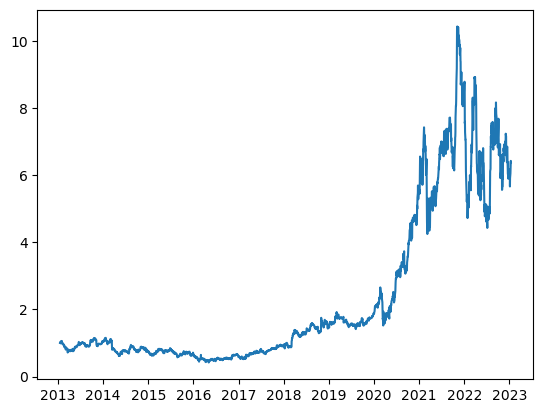

In [75]:
plt.plot(
    (get_daily_returns(data[('AdjClose', EXAMPLE)]) + 1).cumprod());

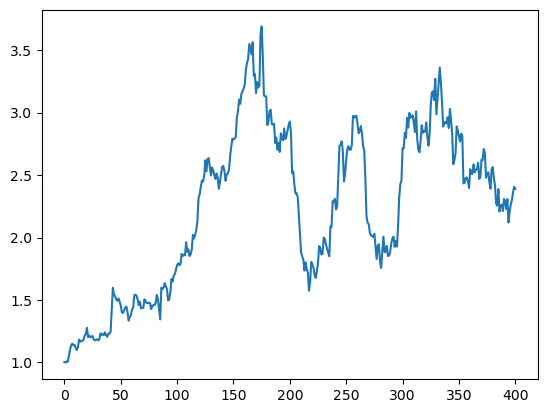

In [76]:
dr = get_daily_returns(
    data[('AdjClose', EXAMPLE)]
)[data.state == CURRENT_STATE]
dr = dr[dr.notnull()]
plt.plot((dr + 1).to_numpy().cumprod());

In [77]:
get_weighted_sharpe(daily_returns, data.copy())

0.9096864734606328

In [78]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    daily_returns = get_daily_returns(stock_data.AdjClose)
    sharpe = get_sharpe(daily_returns)
    #state_sharpe = get_sharpe(
    #    daily_returns[data.state == CURRENT_STATE])
    #hedged_sharpe = get_hedged_sharpe(daily_returns, data)
    weighted_sharpe = get_weighted_sharpe(daily_returns, data)
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (
        stock_data.AdjClose.rolling(window=WINDOW).max())
    stock_data['ann_low'] = (
        stock_data.AdjClose.rolling(window=WINDOW).min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = (
        (stock_data.AdjClose 
         + stock_data.High 
         + stock_data.Low 
         + stock_data.Open) 
        / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    n_notnull_resid = stock_data.resid.notnull().sum()
    stock_data['dev'] = np.nan
    stock_data.loc[stock_data.resid.notnull(), 'dev'] = (
        np.array(range(n_notnull_resid) / n_notnull_resid))
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.AdjClose, label='AdjClose')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(
            np.sqrt(stock_data.drawdown * stock_data.pullup),
            color='grey',
            label='geomean')
        plt.yscale('log')
        plt.legend()
    return (
        stock_data.direction.tolist()[-1],
        stock_data.rsi.tolist()[-1],
        stock_data.resid.tolist()[-1], 
        stock_data.dev.tolist()[-1],
        stock_data.drawdown.tolist()[-1],
        stock_data.pullup.tolist()[-1],
        sharpe,
        #state_sharpe,
        #hedged_sharpe,
        weighted_sharpe)

(1,
 0.38953256092688776,
 0.8490266189908622,
 0.4505363528009535,
 0.05516088591725867,
 0.10906811533639783,
 0.8908509026681783,
 -0.2938936660290407)

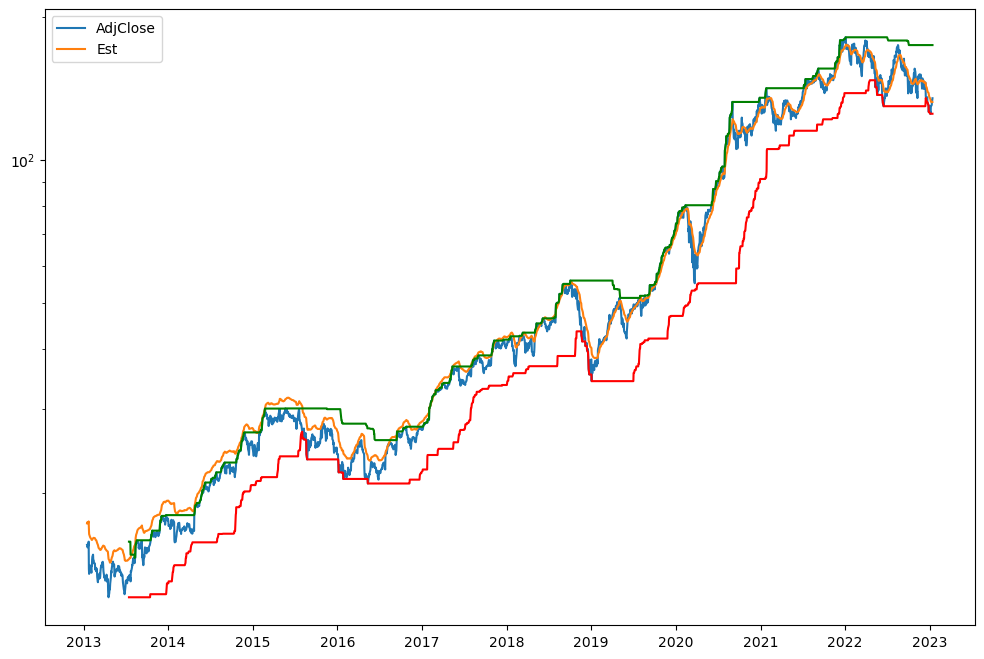

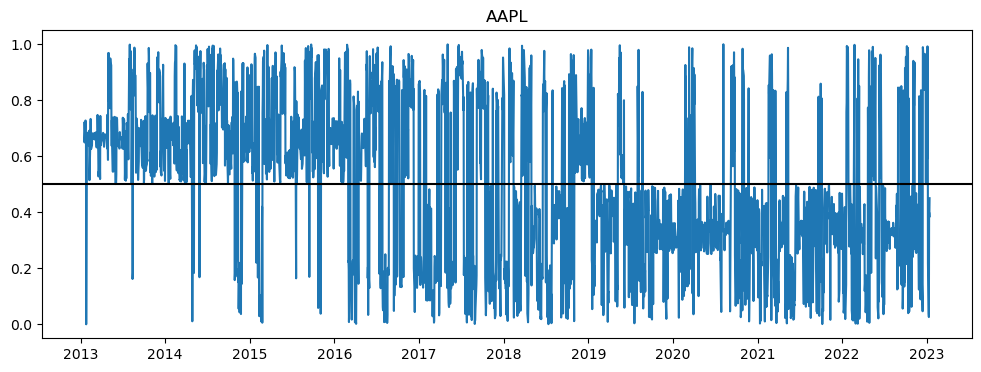

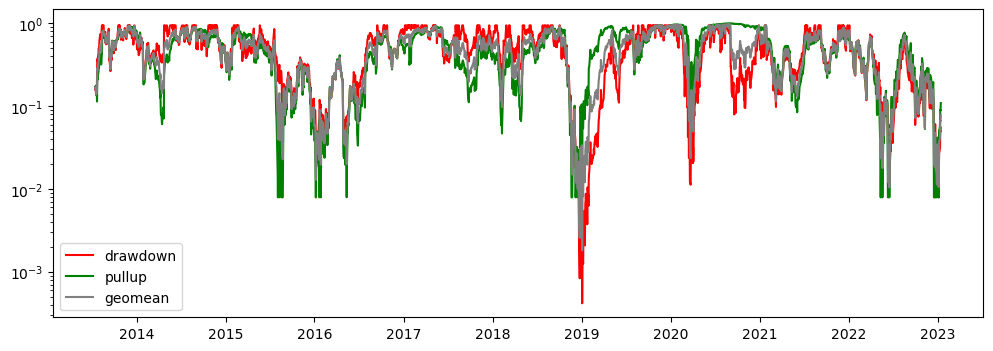

In [79]:
process_stock('AAPL', data.copy(), plot=True)

In [80]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    stock_stats = process_stock(stock, data)
    out.append([stock, *stock_stats])

AAPL... ABMD... ABNB... ACN... ADBE... ADYEY... AGI... AMD... AMEH... AMGN... AMRC... AMRK... AMZN... ANET... APT... ASML... AXON... BROS... BRTX... BTTR... BYND... BYRN... CAR... CEF... CELH... CENN... CGAU... CHEF... CHWY... CLW... COOP... CRWD... CSIQ... CTGO... CVE... DDOG... DGX... DIS... DOCS... DOCU... DQ... DTST... DUOL... DYAI... EA... EDIT... EP... ERIE... ESOA... ESTE... ETSY... FCUV... FKWL... FLGT... FNV... FSI... FTNT... GCBC... GGB... GGE... GH... GME... GMED... GOOG... HBM... HMY... HNRG... IDR... IDXX... INTG... INTZ... ISRG... JD... LFMD... LPLA... LRCX... LSPD... LULU... MA... MASI... MCVT... MDB... MELI... MICS... MNMD... MNST... MOBQ... MSFT... MTA... MTCH... MTDR... NET... NOW... NVCR... NVDA... ODFL... OKTA... OMQS... OPEN... PAC... PACB... PANW... PARR... PAYC... PETV... PINS... POWW... PRIM... PRPH... PTON... PYPL... QDEL... RBLX... RDFN... RGEN... RIVN... RMD... ROKU... RVLV... RVP... RVYL... SAM... SAND... SBUX... SE... SHOP... SIX... SNOW... SOBR... TASK... 

In [81]:
out_df = pd.DataFrame(
    data=out, 
    columns=[
        'stock', 'direction', 'RSI', 'fair_value_mult', 'dev_quantile',
        'drop','climb', 'sharpe', 'weighted_sharpe'])
out_df['geomean'] = np.sqrt(out_df['drop'] * out_df.climb)
out_df['score'] = (
    out_df.fair_value_mult
    * out_df.dev_quantile
    * out_df['drop']
    * out_df.climb) ** (1/4) 
out_df['RSIRev'] = 1 - out_df.RSI
out_df = out_df[
    ['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
     'dev_quantile', 'drop', 'climb', 'geomean', 'score',  'sharpe',
     'weighted_sharpe']]
out_df.RSI.fillna(out_df.RSI.median())
out_df.RSIRev.fillna(out_df.RSIRev.median())

out_df.weighted_sharpe.fillna(
    out_df.weighted_sharpe.mean(), inplace=True)
out_df.sort_values('stock')
out_df.head()

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe,weighted_sharpe
0,AAPL,1,0.389533,0.610467,0.849027,0.450536,0.055161,0.109068,0.077565,0.219026,0.890851,-0.293894
1,ABMD,0,0.921294,0.078706,0.392332,0.807708,0.891141,0.759507,0.822695,0.680529,0.970595,0.779424
2,ABNB,1,0.959064,0.040936,0.950664,0.362429,0.709677,0.563275,0.632253,0.609197,-0.018568,0.067172
3,ACN,1,0.525370,0.474630,0.959873,0.373858,0.146260,0.429168,0.250540,0.387408,0.778887,0.281717
4,ADBE,1,0.507391,0.492609,0.580453,0.244736,0.091935,0.564563,0.227822,0.293031,0.858799,-0.136964


In [82]:
out_df.geomean.quantile([0.05, 0.99])

0.05    0.097620
0.99    0.946173
Name: geomean, dtype: float64

In [83]:
out_df.to_csv('individ_quantiles.csv', index=False)

In [84]:
!open individ_quantiles.csv